In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from itertools import combinations
from scipy.spatial import cKDTree
from IPython.display import display
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['grey', 'orange'])
from sklearn.cluster import DBSCAN
import cv2

import networkx as nx



DATA_PATH = "/home/kartik/layout-analysis/stress-test-data"
SAMPLE_SIZE = 6  #number of pages to process




In [17]:

NUM_NEIGHBOURS = 8
norm_ratio_threshold = 2  # Allows a max ratio of 1.5 between the norms
cos_similarity_less_than = -0.8
# we assume that character spacing is less than line spacing 


%matplotlib widget


In [18]:
def convert_to_graph(to_plot, points):
    # Create an empty graph
    G = nx.Graph()
    
    # Add all points as nodes with their coordinates as features
    for i, point in enumerate(points):
        G.add_node(i, pos=point)
    
    # Add edges from to_plot, avoiding duplicates (NetworkX handles this automatically)
    for center, neighbor1, neighbor2 in to_plot:
        G.add_edge(center, neighbor1)
        G.add_edge(center, neighbor2)
    
    # Create adjacency matrix
    adj_matrix = nx.to_numpy_array(G)
    
    # Create feature matrix (each row contains the x,y coordinates of a point)
    feature_matrix = np.array([G.nodes[i]['pos'] for i in range(len(points))])
    
    return G, adj_matrix, feature_matrix

In [21]:
pg_no = 2
bg_img = plt.imread(DATA_PATH+f"/{pg_no}.jpg")  # Replace with your image path
bg_img = cv2.resize(bg_img, (bg_img.shape[1] // 2, bg_img.shape[0] // 2))
height, width = bg_img.shape[:2]

#TODO
# better clustering (more features)
# what is that horizontal vertical mystery of the stress test page..

Processing file: /home/kartik/layout-analysis/stress-test-data/2.txt


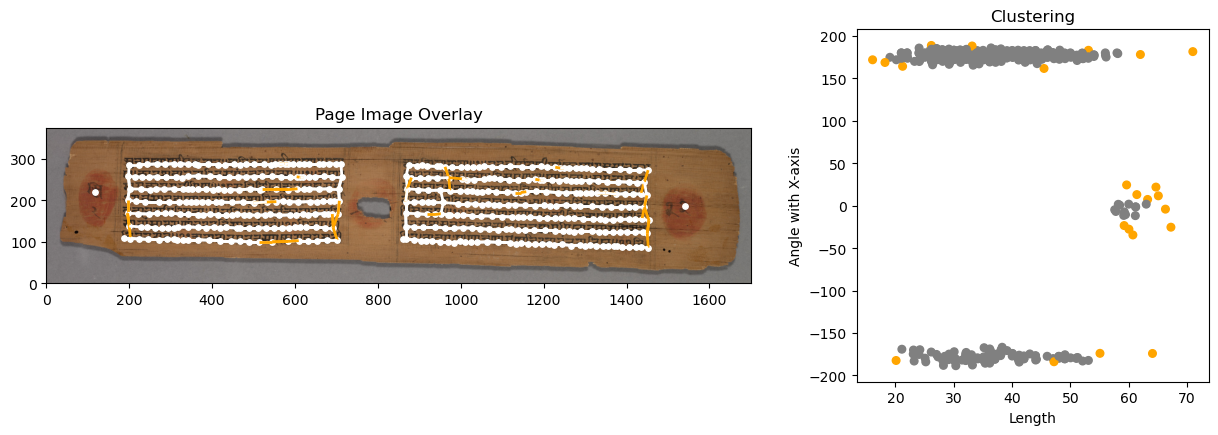

Graph created with 427 nodes and 443 edges
Original connections: 834 (each in to_plot creates 2 connections)
Unique connections after removing duplicates: 443


/tmp/ipykernel_3843683/4109187656.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


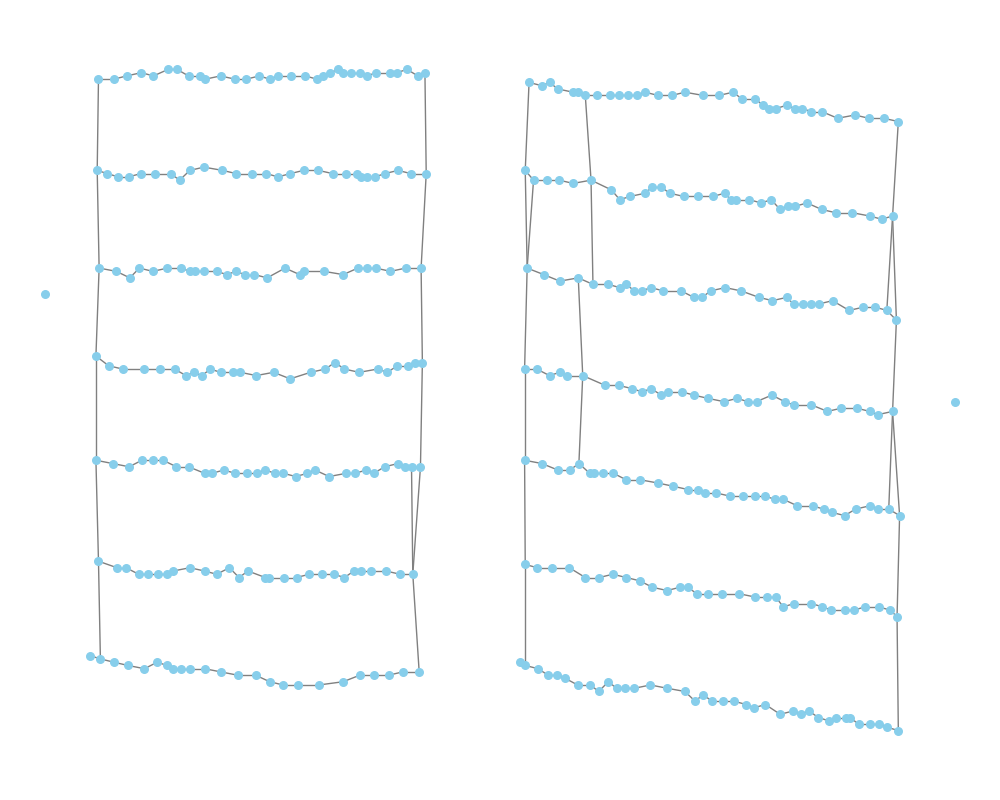

Number of connected components: 4


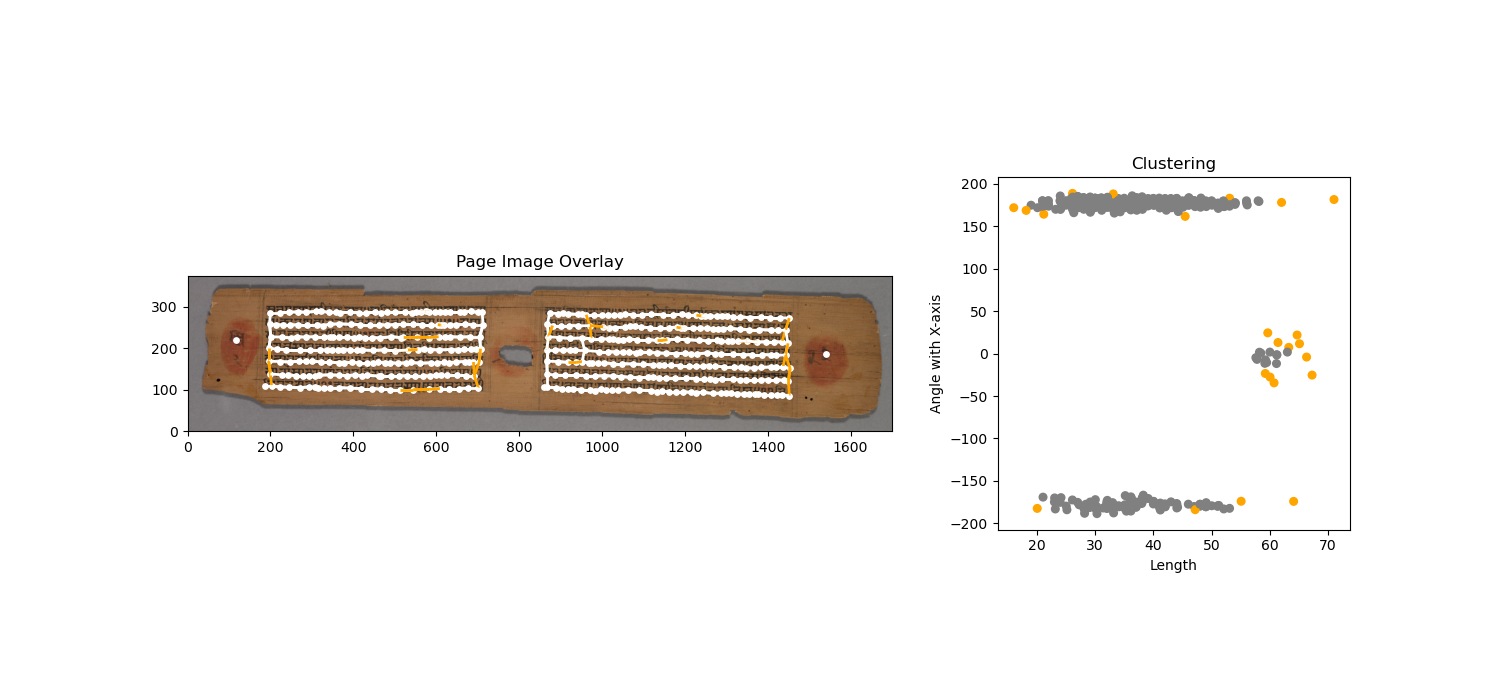

In [22]:
# Get unique prefixes efficiently without sorting everything
for entry in os.scandir(DATA_PATH):
    # if entry.is_file() and entry.name.endswith(f'{pg_no}.txt'):
    if entry.is_file() and entry.name == f'{pg_no}.txt':

        points_file = entry.path
        print(f"Processing file: {points_file}")
        points = np.loadtxt(points_file)
        
        # Build a KD-tree for fast neighbor lookup
        tree = cKDTree(points)
        _, indices = tree.query(points, k=NUM_NEIGHBOURS)
        
        segments = []
        seg_colors = [] 

        to_cluster = []
        global_pair_tracker = []
        to_plot = []

        # Process nearest neighbors
        for current_point_index, nbr_indices in enumerate(indices):
            normalized_points = points[nbr_indices] - points[current_point_index]
            scaling_factor = np.max(np.abs(normalized_points))
            if scaling_factor == 0:
                scaling_factor = 1
            scaled_points = normalized_points / scaling_factor
            relative_neighbours = [(global_idx, sp, np)
                                   for global_idx, sp, np in zip(nbr_indices, scaled_points, normalized_points)]
            

            filtered_neighbours = []
            for _a, _b in combinations(relative_neighbours, 2):
                # calculate the angle between the two pair vectors
                if np.linalg.norm(_a[1]) * np.linalg.norm(_b[1]) == 0:
                    cos_similarity = 0.0
                else:
                    cos_similarity = np.dot(_a[1], _b[1]) / (np.linalg.norm(_a[1]) * np.linalg.norm(_b[1]))

                # calculate the non-normalized length of the pair
                norm1 = np.linalg.norm(_a[2])
                norm2 = np.linalg.norm(_b[2])
                total_length = norm1 + norm2

                # select pairs who have an angle of around 180 degrees between them
                if cos_similarity < cos_similarity_less_than:
                    filtered_neighbours.append((_a, _b, total_length, cos_similarity))

            if filtered_neighbours:
                # select the pair with the shortest total_length (sometimes, the 2nd shortest is the right answer)
                shortest_pair = min(filtered_neighbours, key=lambda x: x[2])
                global_pair_tracker.append(shortest_pair)

                _connection_1, _connection_2, total_length, cos_similarity = shortest_pair
                global_idx_connection_1 = _connection_1[0]
                global_idx_connection_2 = _connection_2[0]

                # calculate the angles made with the X-axis for clustering purpose
                theta_a = np.degrees(np.arctan2(_connection_1[2][1], _connection_1[2][0]))
                theta_b = np.degrees(np.arctan2(_connection_2[2][1], _connection_2[2][0]))
                theta = (theta_a,theta_b)
                
                to_plot.append((current_point_index, global_idx_connection_1, global_idx_connection_2))
                to_cluster.append((total_length, theta[0]+theta[1]))


        to_cluster_array = np.array(to_cluster)  # Convert list to NumPy array

        # Run DBSCAN (adjust eps and min_samples as needed)
        dbscan = DBSCAN(eps=3, min_samples=2)  # Tune these parameters
        labels = dbscan.fit_predict(to_cluster_array)
        colors = np.zeros(len(to_cluster))
        # Mark outliers (DBSCAN assigns -1 to outliers)
        colors[labels == -1] = 1
    
        # Adjust figure layout: large left panel for nearest neighbors, smaller right panel for scatter plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), 
                                       gridspec_kw={'width_ratios': [2, 1]})  # Left panel is twice the width
        #ax1.set_box_aspect(1)  # Keep the box aspect ratio equal for both axes
        ax2.set_box_aspect(1)  
        
        # Nearest neighbors plot (left)
        for i,s in enumerate(to_plot):
            seg1 = (points[s[0]], points[s[1]])
            seg2 = (points[s[0]], points[s[2]])
            segments.extend([seg1, seg2])
            segment_color = 'orange' if colors[i] == 1 else 'white'
            seg_colors.extend([segment_color, segment_color])

        ax1.imshow(bg_img, alpha=1, zorder=0, extent=[0, width, 0, height])
        ax1.set_xlim(0, width)
        ax1.set_ylim(0, height) 
        base_lc = mc.LineCollection(segments, linewidths=2, alpha=1, colors=seg_colors)
        ax1.add_collection(base_lc)
        ax1.scatter(points[:, 0], points[:, 1], c='white', s=15)
        ax1.set_title("Page Image Overlay")



        # Scatter plot (right)
        distances, cos_similarities = zip(*to_cluster) if to_cluster else ([], [])
        scatter = ax2.scatter(distances, cos_similarities, c=colors,cmap=cmap, s=30, alpha=1, picker=True)
        ax2.set_xlabel('Length')
        ax2.set_ylabel('Angle with X-axis')
        ax2.set_title('Clustering')

        # Interactive Highlighting
        highlighted_segments = [None]

        def on_pick(event):
            if event.artist != scatter:
                return
            if len(event.ind) == 0:
                return

            i = event.ind[0]
            s = to_plot[i]
            seg1 = (points[s[0]], points[s[1]])
            seg2 = (points[s[0]], points[s[2]])
            
            if highlighted_segments[0] is not None:
                highlighted_segments[0].remove()
                highlighted_segments[0] = None

            highlighted_segments[0] = mc.LineCollection([seg1, seg2], linewidths=6, colors='black')
            ax1.add_collection(highlighted_segments[0])
            fig.canvas.draw_idle()

        fig.canvas.mpl_connect('pick_event', on_pick)

        # Display the interactive figure (keeps multiple figures interactive)
        display(fig)

        # Create the graph and matrices
        G, adjacency_matrix, feature_matrix = convert_to_graph(to_plot, points)

        # Print some statistics about the graph
        print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        print(f"Original connections: {len(to_plot)*2} (each in to_plot creates 2 connections)")
        print(f"Unique connections after removing duplicates: {G.number_of_edges()}")

        # Visualize the graph structure (optional)
        plt.figure(figsize=(10, 8))
        pos = {i: point for i, point in enumerate(points)}
        nx.draw(G, pos, with_labels=False, node_size=30, node_color='skyblue', edge_color='gray')
        plt.title("Graph representation")
        plt.tight_layout()
        plt.show()

        # Save matrices if needed
        np.save(f'adjacency_matrix_page_{pg_no}.npy', adjacency_matrix)
        np.save(f'feature_matrix_page_{pg_no}.npy', feature_matrix)

        # Optional: If you want to analyze connected components
        connected_components = list(nx.connected_components(G))
        print(f"Number of connected components: {len(connected_components)}")

In [13]:
#TODO
# image to heatmap to pointcloud -- has to be consistent
# ensure consistant connection (over scale and rotation)
# anomaly detection - remove
                                
